딥러닝 기초 스터디 / 박찬영

# 📌 6.1. 이미지 분류를 위한 신경망

☑️ **6.1.1. LeNet-5 (1995)**

In [ ]:
!pip install --user tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim  # 옵티마이저 (경사 하강법 이용)
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms  # 이미지 변환(전처리)

import os
import cv2  # OpenCV는 BGR 순서
import random
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([  # 이미지 변형 방식
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),  # resize로 크기로 조정 + scale로 자르기
                transforms.RandomHorizontalFlip(),  # 50% 확률로 이미지 수평 반전
                transforms.ToTensor(),  # PIL (H x W x C, 0~255) -> Tensor (C x H x W, 0.0~1.0)
                transforms.Normalize(mean, std)  # 정규화 (RGB 채널마다 평균과 표준편차)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("drive/MyDrive/프로메테우스 스터디")

cat_directory = r'chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'chap06/data/dogs-vs-cats/Dog/'

# 이미지 데이터 가져오기
cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in
                              os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in
                              os.listdir(dog_directory)])
# 이미지 파일 경로
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]  # test (400)
val_images_filepaths = correct_images_filepaths[400:-10]  # validation (92)
test_images_filepaths = correct_images_filepaths[-10:]  # test (10)
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
400 92 10


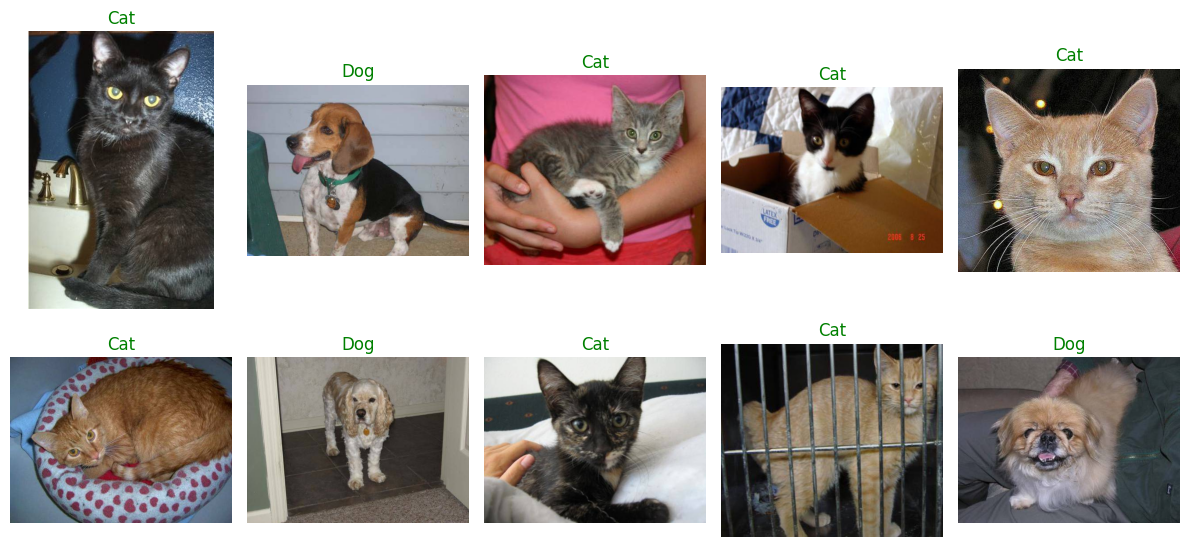

In [ ]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 이미지 색상 변경 (BGR -> RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"  # Green = (예측 == 실제), Red = (예측 != 실제)
        ax.ravel()[i].imshow(image)  # 이미지 출력
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()  # 여백 조정
    plt.show()

display_image_grid(test_images_filepaths)

In [ ]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):  # 데이터 전처리
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):  # 데이터셋의 전체 길이 반환
        return len(self.file_list)

    def __getitem__(self, idx):  # 데이터셋에서 데이터를 가져오는 부분 (Tensor)
        img_path = self.file_list[idx]
        img = Image.open(img_path)  # 이미지 데이터
        img_transformed = self.transform(img, self.phase)  # ImageTransform() 객체
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

In [ ]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size,  mean, std), phase='val')

index = 0
print("이미지 하나의 크기 :", train_dataset.__getitem__(index)[0].size())  # 크기
print("이미지 레이블 :", train_dataset.__getitem__(index)[1])  # 레이블
print()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 배치 관리
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print("이미지 배치의 크기 :", inputs.size())
print("이미지 배치 레이블 :", label)

이미지 하나의 크기 : torch.Size([3, 224, 224])
이미지 레이블 : 0

이미지 배치의 크기 : torch.Size([32, 3, 224, 224])
이미지 배치 레이블 : tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 0, 0])


In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 입력 : (3, 224, 224)
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)  # (16, 220, 220)

        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # (16, 110, 110)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)  # (32, 106, 106)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)  # (32, 53, 53)

        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)  # 완전연결층 -> 데이터 형태 1차원
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        return out

model = LeNet()
print(model)

from torchsummary import summary
summary(model, input_size=(3,224,224))  # 채널 x 너비 x 높이

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 46,038,242 trainable parameters


In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # 가중치 변경 - lr 얼마나 크게 변경, momentum 흔들림 줄여감
criterion = nn.CrossEntropyLoss()  # reduction='mean'

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
import time

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):  # epoch 반복
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):  # 훈련 데이터셋(train_loader)
                inputs = inputs.to(device)  # 훈련 데이터셋을 CPU/GPU에 할당
                labels = labels.to(device)
                optimizer.zero_grad()  # 기울기(gradient)를 0으로 초기화

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # 오차 계산

                    if phase == 'train':
                        loss.backward()  # 모델의 학습 가능한 모든 파라미터에 대해 기울기를 계산
                        optimizer.step()  # optimizer의 step 함수를 호출하면 파라미터를 갱신

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)  # 정답과 예측이 일치

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)  # 최종 오차 계산
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)  # 최종 정확도 계산

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'val' and epoch_acc > best_acc:  # 가장 최적의 정확도 저장
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [ ]:
import time

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-18-73cdf90efbd6>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):  # 훈련 데이터셋(train_loader)


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.5375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7017 Acc: 0.4891
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6880 Acc: 0.5500


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7081 Acc: 0.4891
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6827 Acc: 0.5750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7123 Acc: 0.4348
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6715 Acc: 0.5775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7102 Acc: 0.5217
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6715 Acc: 0.6075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7061 Acc: 0.4891
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6600 Acc: 0.6000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7085 Acc: 0.5217
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6594 Acc: 0.6175


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7017 Acc: 0.5543
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6557 Acc: 0.6250


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6899 Acc: 0.5652
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6458 Acc: 0.6475


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6858 Acc: 0.5435
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6448 Acc: 0.6375


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.7048 Acc: 0.5543
Training complete in 6m 34s
Best val Acc: 0.565217


In [ ]:
import pandas as pd

id_list = []
pred_list = []
_id = 0
with torch.no_grad():  # Test : 역전파 중 텐서들에 대한 변화도를 계산할 필요 X
    for test_path in tqdm(test_images_filepaths):  # 테스트 데이터셋
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)  # 차원 추
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])

result = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})  # 테스트 데이터셋의 예측 결과인 id, label

result.sort_values(by='id', inplace=True)
result.reset_index(drop=True, inplace=True)
result.head()
# result.to_csv('chap06/data/LeNet', index=False)

<ipython-input-20-287ed8af710c>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):  # 테스트 데이터셋


  0%|          | 0/10 [00:00<?, ?it/s]

,id,label
0,109,0.330457
1,145,0.303072
2,15,0.447225
3,162,0.344858
4,167,0.445427


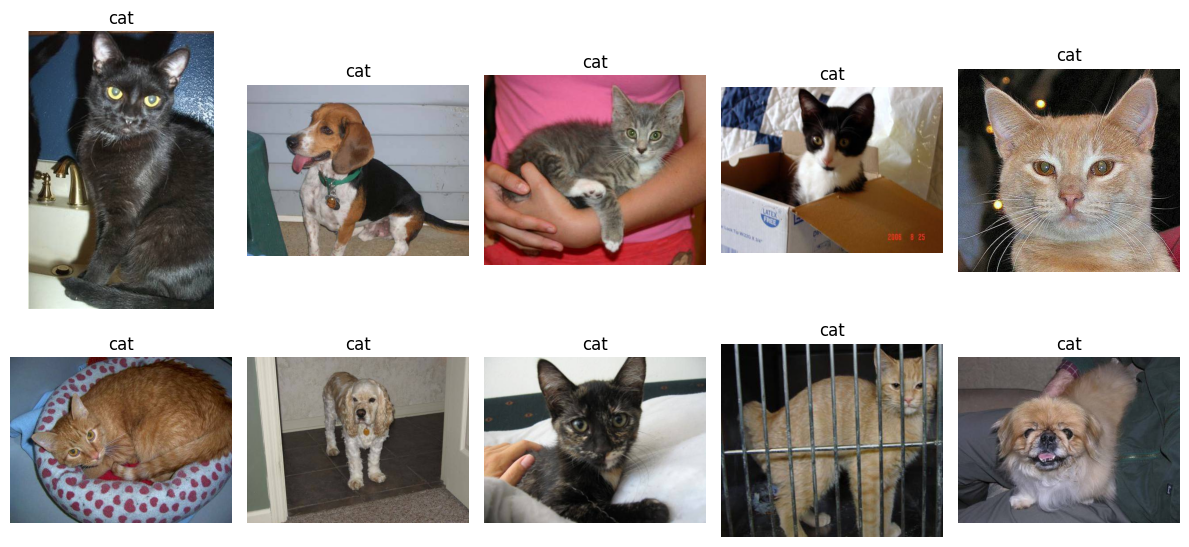

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}  # 클래스 정의

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # a = random.choice(result['id'].values)  # 임의의 데이터  --> 이상한데?
        id = os.path.normpath(image_filepath).split(os.sep)[-1].split(".")[1]
        label = result.loc[result['id'] == id, 'label'].values[0]
        if label > 0.5:  # 개
            label = 1
        else:  # 고양이
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)


\

---


\

☑️ **6.1.2. AlexNet (2012)**

In [ ]:
!pip install --user tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim  # 옵티마이저 (경사 하강법 이용)
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms  # 이미지 변환(전처리)

import os
import cv2  # OpenCV는 BGR 순서
import random
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5,1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }

    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("drive/MyDrive/프로메테우스 스터디")

cat_directory = r'chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'chap06/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

400 92 10


In [ ]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # 파일 경로
        self.transform = transform  # 이미지 데이터 전처리
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)

        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0

        return img_transformed, label

In [ ]:
size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

train_dataset = DogvsCatDataset(train_images_filepaths, transform=ImageTransform(size, mean, std), phase='train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')
test_dataset = DogvsCatDataset(val_images_filepaths, transform=ImageTransform(size, mean, std), phase='val')

index = 0
print("이미지 하나의 크기 :", train_dataset.__getitem__(index)[0].size())  # 크기
print("이미지 레이블 :", train_dataset.__getitem__(index)[1])  # 레이블
print()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # 배치 관리
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {'train': train_dataloader, 'val': val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print("이미지 배치의 크기 :", inputs.size())
print("이미지 배치 레이블 :", label)

이미지 하나의 크기 : torch.Size([3, 256, 256])
이미지 레이블 : 0

이미지 배치의 크기 : torch.Size([32, 3, 256, 256])
이미지 배치 레이블 : tensor([1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 1])


In [ ]:
class AlexNet(nn.Module):
    def __init__(self) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),  # 기존 데이터 대체
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  # 풀링 작업이 끝날 때 필요한 출력 크기를 정의
        # AvgPool2d -> 커널 크기, 스트라이드, 패딩 지정
        # AdaptiveAvgPool2d -> 출력 크기 지정 (커널 크기, 스트라이드, 패딩 값 정해짐)
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 2),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = AlexNet()
model.to(device)

from torchsummary import summary
summary(model, input_size=(3,224,224))  # 채널 x 너비 x 높

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):

    since = time.time()
    best_acc = 0.0

    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
          time_elapsed // 60, time_elapsed % 60))
    return model

num_epoch = 10
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


<ipython-input-45-8033b2eb9f6f>:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.5109
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6936 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.5109
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6932 Acc: 0.5109
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6931 Acc: 0.5109
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6932 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935 Acc: 0.5025


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930 Acc: 0.5109
Training complete in 9m 59s


In [ ]:
import pandas as pd
id_list = []
pred_list = []
_id = 0
with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):  # 테스트 이미지 데이터
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase='val')
        img = img.unsqueeze(0)
        img = img.to(device)

        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

result = pd.DataFrame({
    'id': id_list,
    'label': pred_list
})  # 테스트 데이터셋의 예측 결과인 id, label

result.sort_values(by='id', inplace=True)
result.reset_index(drop=True, inplace=True)
result.head()
# result.to_csv('chap06/data/alexnet.csv', index=False)

<ipython-input-46-2968eaca0d53>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):  # 테스트 이미지 데이터


  0%|          | 0/10 [00:00<?, ?it/s]

,id,label
0,109,0.508904
1,145,0.508855
2,15,0.508942
3,162,0.509416
4,167,0.509419


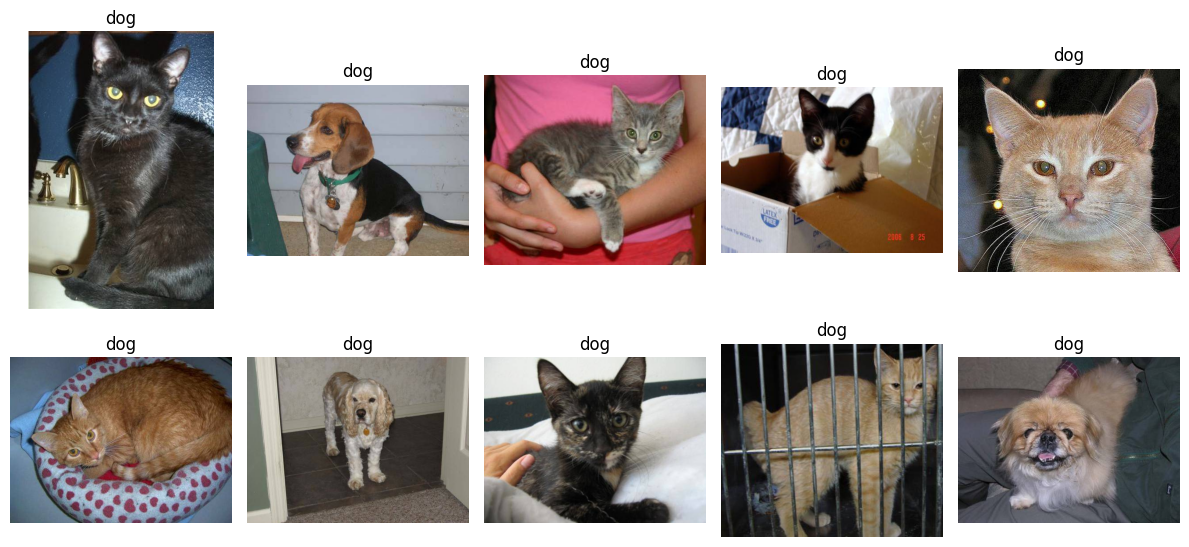

In [ ]:
class_ = classes = {0:'cat', 1:'dog'}

def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # a = random.choice(result['id'].values)  # 임의의 데이터  --> 이상한데?
        id = os.path.normpath(image_filepath).split(os.sep)[-1].split(".")[1]
        label = result.loc[result['id'] == id, 'label'].values[0]
        if label > 0.5:
            label = 1
        else:
            label = 0
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_image_grid(test_images_filepaths)

\

---

\

☑️ **6.1.3. VGGNet (2015)**

In [1]:
!pip install --user tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim  # 옵티마이저 (경사 하강법 이용)
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms  # 이미지 변환(전처리)

import numpy as np
import copy
import os
import cv2  # OpenCV는 BGR 순서
import random
import time
from PIL import Image
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

# 8(합성곱층) + 3(풀링층) = 11(전체 계층) = VGG11
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']
# 10(합성곱층) + 3(풀링층) = 13(전체 계층) = VGG13
vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512,  'M']
# 13(합성곱층) + 3(풀링층) = 16(전체 계층) = VGG16
vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
# 16(합성곱층) + 3(풀링층) = 19(전체 계층) = VGG19
vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']

In [3]:
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':  # 'M' -> 최대 풀링(MaxPool2d)
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:  # 숫자 -> 합성곱(Conv2d)
            conv2d = nn.Conv2d(in_channels, c, kernel_size=3, padding=1)
            if batch_norm:  # 배치 정규화(batch normalization) : 평균 0, 표준편차 1 분
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace=True)]  # 배치 정규화+ReLU 적용
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]  # ReLU만 적용
            in_channels = c

    return nn.Sequential(*layers)  # 네트워크의 모든 계층 반환

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm=True)
print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [4]:
OUTPUT_DIM = 2  # 2개 클래스 (개, 고양이)
model = VGG(vgg11_layers, OUTPUT_DIM)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [5]:
import torchvision.models as models
pretrained_model = models.vgg11_bn(pretrained=True)  # 사전 학습된 모델 (배치 정규화 적용)
print(pretrained_model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:10<00:00, 51.5MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [6]:
train_transforms = transforms.Compose([
                        transforms.Resize((256, 256)),  # 크기 재조정
                        transforms.RandomRotation(5),  # 5도 이하로 이미지 회전
                        transforms.RandomHorizontalFlip(0.5),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,  0.224, 0.225])])

test_transforms = transforms.Compose([
                        transforms.Resize((256, 256)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,  0.224, 0.225])])

In [7]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("drive/MyDrive/프로메테우스 스터디")

train_path = 'chap06/data/catanddog/train'
test_path = 'chap06/data/catanddog/test'

# ImageFolder - 계층적인 폴더 구조 데이터셋 불러올 때 사
train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

Mounted at /content/drive
529
12


(None, None)

In [8]:
VALID_RATIO = 0.9
n_train_examples = int(len(train_dataset) * VALID_RATIO)  # 훈련 데이터셋 (훈련의 90%)
n_valid_examples = len(train_dataset) - n_train_examples  # 검증 데이터셋 (훈련의 10%)

from torch.utils.data import random_split
train_data, valid_data = random_split(train_dataset, [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 476
Number of validation examples: 53
Number of testing examples: 12


In [9]:
BATCH_SIZE = 128
train_iterator = DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = DataLoader(test_dataset,
                                 batch_size=BATCH_SIZE)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=1e-7)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()  # view_as(other) == view(other.size()) : 같은 크기로 변경
    acc = correct.float() / y.shape[0]
    return acc

In [11]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [12]:
EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)  # 훈련 데이터셋
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)  # 검증 데이터셋

    if valid_loss < best_valid_loss:  # valid_loss가 가장 작은 값
        best_valid_loss = valid_loss
        # torch.save(model.state_dict(), 'chap06/data/VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} | Valid. Acc: {valid_acc*100:.2f}%')

OutOfMemoryError: CUDA out of memory. Tried to allocate 256.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 62.12 MiB is free. Process 12851 has 14.68 GiB memory in use. Of the allocated memory 13.90 GiB is allocated by PyTorch, and 658.61 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
model.load_state_dict(torch.load('chap06/data/VGG-model.pt'))  # 모델 불러오기
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

In [ ]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)  # 열(axis=1) 따라 가장 큰 값 색인 찾기, 출력 텐서를 입력과 동일한 크기 유지
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)  # 행(axis=0) 따라 이어 붙이기
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)
    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)
corrects = torch.eq(labels, pred_labels)
correct_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if correct:
        correct_examples.append((image, label, prob))

correct_examples.sort(reverse=True, key=lambda x: torch.max(x[2], dim=0).values)

In [ ]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min=image_min, max=image_max)  # 최소(min), 최대(max)의 범주에 이미지가 위치하도록 만듦
    image.add_(-image_min).div_(image_max-image_min+1e-5)  # torch.add_는 기존 메모리 값 대체 (torch.add는 새로운 메모리 공간 할당)
    return image

def plot_most_correct(correct, classes, n_images, normalize=True):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize=(25,20))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = correct[i]
        image = image.permute(1, 2, 0)  # 축 변경
        true_prob = probs[true_label]
        correct_prob, correct_label = torch.max(probs, dim=0)
        true_class = classes[true_label]
        correct_class = classes[correct_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {correct_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

classes = test_dataset.classes
N_IMAGES = 5
plot_most_correct(correct_examples, classes, N_IMAGES)